# Natural Language Systems (COMP34112) 
# Alexander Angelov<br>
## Coursework 1 (Task 2)

Importing the necessary libraries and downloading the corpuses(if needed).

In [1]:
from nltk import *
import numpy as np
from sklearn.cluster import KMeans
import copy
import string
from random import *
import matplotlib.pyplot as plt
#download('brown')
#download('stopwords')
#download('product_reviews_2')

#### Loading the data from the target words list into an array.

In [2]:
with open("./target-words.txt",'r') as target_words_file:
	target_words = target_words_file.readlines()
target_words = [word.strip("\n") for word in target_words]



stopwords = corpus.stopwords.words('english')
porter_stemmer = PorterStemmer()

#### Function creating context for each occurence of a word in a given target word list.<br> 
The function gets a corpus containing data from different documents and target words as arguments and returns an array consisting of shorter arrays each containing context of a target word for given context size. In addition, stemming, stopword removal, or context resize can be applied to the given data.<br>
At the beginning, we remove all special symbols and digits from the original corpus. Afterwards, it is separated into smaller contexts/chunks depending on the target words list and the context size.

In [3]:
def corpus_representation(corpora_list,target_words,context_size=5,remove_stopwords=False,stemming=False):

    new_corpora = []
    for corpora in corpora_list:
        for document_id in corpora.fileids():
            document_corpus = corpora.words(fileids=[document_id])

            corpora_after_symbol_removal = []
            for word in document_corpus:
                for symbol in string.punctuation:
                    word = word.replace(symbol, "")
                for symbol in string.digits:
                    word = word.replace(symbol, "")
                if remove_stopwords:
                    if word.lower() in stopwords and not (word.lower() in target_words):
                        word == ""
                if stemming:
                    if not (word.lower() in target_words):
                        word = porter_stemmer.stem(word)

                if word != "":
                    corpora_after_symbol_removal.append(word)
                
            for word_number in range(len(corpora_after_symbol_removal)):
                if corpora_after_symbol_removal[word_number] in target_words:
                    if word_number - context_size < 0:
                        window_start = 0
                    else:
                        window_start = word_number - context_size

                    if word_number + context_size + 1 > len(corpora_after_symbol_removal):
                        window_end = len(corpora_after_symbol_removal)
                    else:
                        window_end = word_number + context_size + 1

                    context_window = corpora_after_symbol_removal[window_start:window_end]
                    new_corpora.append(context_window)
    return new_corpora

#### Function creating a word-by-word matrix from the created smaller contexts and a given target list.<br>
Firstly, a matrix is created full of zeros with size m * n, where m is the size of the target words list and n is the number of different tokens in the updated corpus. Each cell in the matrix is incremented with 1 if it is found in a smaller context together with the target word corresponding to the row of the cell.

In [4]:
def get_word_by_word_matrix(target_words,corpora):
	corpora_words = []
	for context_window in corpora:
		corpora_words += context_window
		
	word_dictionary = list(set(corpora_words))
	word_matrix = np.zeros((len(target_words),len(word_dictionary)))
	
	for target_word_id in range(len(target_words)):
		for context_window in corpora:
			target_word_count = 0
			if context_window.count(target_words[target_word_id]) > 0:
				for word in context_window:
					if word!= target_words[target_word_id]:
						word_matrix[target_word_id][word_dictionary.index(word)] += 1
					else:
						if target_word_count >= 1 and word == target_words[target_word_id]:
							word_matrix[target_word_id][word_dictionary.index(word)] += 1
						target_word_count += 1
	return word_matrix

Functions for:
<ol>
<li>Getting all positions of the given word in a given corpus.</li>
<li>Reversing a word.</li>
<li>Reversing half of the occurences of every word from a given target word list in in the corpus and returning the new one.</li>
</ol>

In [5]:
def get_word_occurrencies(target_list,word):
	return [word_index for word_index, word_value in enumerate(target_list) if word_value == word]
	
def reverse_word(word):
	return word[::-1]

def reverse_corpus(target_words,corpora):
	new_corpura = copy.deepcopy(corpora)
	for target_word in target_words:
		context_number = -1
		occurrences = []
		for context_window in corpora:
			context_number += 1
			if context_window.count(target_word) > 0:
				target_word_occurrencies = get_word_occurrencies(context_window,target_word)
				for location in target_word_occurrencies:
					occurrences.append((context_number,location))
		reverse_words = sample(occurrences, len(occurrences) // 2)
		for word in reverse_words:
			new_corpura[word[0]][word[1]] = reverse_word(target_word)
	return new_corpura

### A) Implementation
#### Using the Brown corpus to classify 50 target words into 50 clusters.
Firstly, I apply the function to get the new corpus representation. Secondly, the word-by-word matrix was made for the given set of target words. Thirdly, a K-means classifier was used for the matrix to classify our words into 50 different clusters.

In [6]:
brown_corpus = corpus_representation([corpus.brown],target_words)
target_matrix = get_word_by_word_matrix(target_words,brown_corpus)
print(target_matrix.shape)
clusted_data = KMeans(50).fit(target_matrix)
print(clusted_data.labels_)

(50, 15648)
[46 32 31 43 10 39 47  3 27 15 17 41 45  5  0 13 41 36 20  6  7 11 41 38
 29 28 37  2 42 12 30 18  8 24  4 40  9 22 14 23 19 25 35 21  1 16 33 34
 26 44]


/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: ConvergenceWarning: Number of distinct clusters (48) found smaller than n_clusters (50). Possibly due to duplicate points in X.
  after removing the cwd from sys.path.


### B) Evaluation


Creating a new list of target words, containing the given target words and their reversed.

In [7]:
updated_target_words = copy.copy(target_words)
for index in range(len(target_words)):
	updated_target_words.append(reverse_word(target_words[index]))

The function is analyzing how many words can be paired correctly when using the K-means clustering (with 50 clusters) on the reversed corpus. The process is repeated 5 times. The correct pairs per iteration are visualized and the accuracy per iteration is displayed. At the end the average accuracy of all five iterations is returned.

In [8]:
def get_avarage_accuracy(corpora,target_words,context_size=5,remove_stopwords=False,stemming=False,printing=True):
    corpus_data = corpus_representation(corpora,target_words,context_size,remove_stopwords,stemming)

    times = 0
    average_accuracy = 0
    repeating_times = [1,2,3,4,5]
    correct_pairs_array = []
    while times < 5:
        times += 1
        print(str(times) + " time\n")
        
        new_corpus_data = reverse_corpus(target_words,corpus_data)

        target_matrix = get_word_by_word_matrix(updated_target_words,new_corpus_data)

        clusted_data = KMeans(50).fit(target_matrix)

        cluster_labels = clusted_data.labels_
        if printing:
            print(cluster_labels)

        correct_pairs = 0

        for word_pair in range(len(cluster_labels) // 2):
            if cluster_labels[word_pair] == cluster_labels[word_pair + len(target_words)]:
                correct_pairs += 1
                
        correct_pairs_array.append(correct_pairs)
        print("Accuracy: " + str(correct_pairs/len(target_words)) + "\n")
        average_accuracy += correct_pairs/len(target_words)
    plt.bar(repeating_times,correct_pairs_array)
    plt.xlabel('Iteration')
    plt.ylabel('Correct pairs')
    plt.title('Correct pairs per iteration')
    for i in range(len(correct_pairs_array)):
        plt.annotate(str(correct_pairs_array[i]), xy=(repeating_times[i],correct_pairs_array[i]), ha='center', va='bottom')
    plt.show()
    print("The avarage accuracy is: " + str(average_accuracy / 5) + "\n")
    print("######################################################################################################")
    return average_accuracy / 5

### C) Analysis
#### Running the program on the Product reviews corpus with different features (stopword removal, stemming or different context size).

##### No additional features applied.

No stemming and no stopword removal

1 time

[ 1 11 16 38 16  1  1  0 45 21 35  1  8 42  1 30  1 40  1  7 16 46  1 44
  6  1  1 41 48 16  1  1 29  5 16  2 23 39  1  1 15 18  1 25  3  1 26 16
 34  1  1 28 16 47 16  1  1 20 22 49 31  1 13 32  1 36  1 16  1 27 16 24
  1 44  6  1  1 16 16 16  1  1 41  9 16 12  4 43  1  1 19 33  1 17 14  1
 10  1 37  1]
Accuracy: 0.48

2 time

[ 8 27 46 18 46  8  8 13  5 21 28  8 11 35  8 36  8 44  8 19 46 22  8 47
 25  8  8 49 46 39  8  8 46 14 18  7 15 43  8  8 29 26  8 23  3  8 17  1
 33  8  8 30 46 18 46  8  8 12 32 37 31  8  0 45  8 40  8 46  8  6 39 41
  8  1 25  8  8 46  8 39  8  8 48  4 46 16 24 34  8  8 10 38  8 20  9  8
  2  1 42  8]
Accuracy: 0.46

3 time

[26 30 42 41 42 26 26 17 40 43 19 26 16 37 26 36 26 45 26  7 14 39 26 49
 48 26 26 42  9 47 26 26 38 11 41 15  4 34 26 26 10 31 26 33 12  9  8  1
 27 26 26 24 42 41 42 26 26  2 44 23 28 26  3 46 26 35 26 47 26 25 14 39
 26  1 48 26 26 42  9 42 26 26 42  0 47  6 18 20 26 26 21 22 26 32  5 26
 13

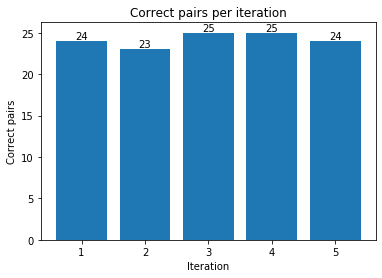

The avarage accuracy is: 0.484

######################################################################################################


In [9]:
################################################################################## No stopword and no stemming
accuracy_list = []
print("No stemming and no stopword removal\n")
accuracy_list.append(get_avarage_accuracy([corpus.product_reviews_2],target_words))

##### Applying only stopword removal.

Stopword removal only

1 time

[22 31 16 43  8 22 22 13 42 28 34 22  3 47 22 40 22  8 22 21  8 38 22 41
 35 22 22 46  0 16 22 22 39  7 39 18 20 45 22 22 11 30 22 32  2  8  1  8
 29 22 22  6  8 43  8 22 22 15 25 44  9 22 19 36 22 33 22 39 22  5 16 38
 22 48  8 22 22  8  8 16 22 22 49 12 16  4 24 37 22 22 23 17 22 26 10 22
 14  8 27 22]
Accuracy: 0.42

2 time

[ 1 28 46 36 46  1  1  0 35 31 23  1 12 41  1 45  1 48  1 19 17 21  1 17
 39  1  1 46 47 17  1  1 40  3 36 11 14 42  1  1 10 32  1 22  2  1 13  1
 26  1  1  8 46 36  1  1  1 25 29 33 38  1  7 37  1 30  1 49  1  9 17 21
  1 43 39  1  1 46 47 46  1  1  4 16 17  5 27 24  1  1 18 44  1 20  6  1
 15  1 34  1]
Accuracy: 0.5

3 time

[20 10 40 34  4 20 20 22 47 43 23 20  1 37 20 36 20 45 20 11 34 39 20 14
 48 20 20  0  4 34 20 20 14  6 34  7  2 38 20 20 25 19 20  9  3 20 21  4
 31 20 20 27 40 42  4 20 20 16 32 26 33 20 13 41 20 46 20 44 20 24  4 39
 20 14 48 20 20 40  4 34 20 20 49 18 34 17 28 30 20 20 15 29 20 12  8 20
  5  4 35 20]
Accu

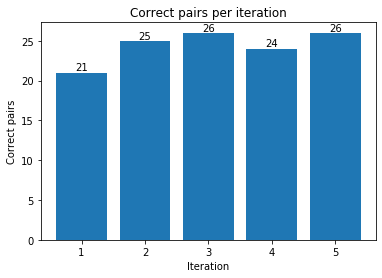

The avarage accuracy is: 0.488

######################################################################################################


In [10]:
################################################################################## Stopword and no stemming
print("Stopword removal only\n")
accuracy_list.append(get_avarage_accuracy([corpus.product_reviews_2],target_words,remove_stopwords = True))

##### Applying only stemming.

Stemming only

1 time

[ 1 26  5 42  5  1  1  8 41 31 18  1  9 45  1 39  1 28  1 11  5 10  1 47
 25  1  1  5 47 44  1  1 40 19 35  6 16 32  1 49 20 24  1 23  2  1 21  1
 38  1  1 13  5 42  5  1  1 27 15 31 29  1 22 45  1 37  1 36  1 30 45 46
  1  5 48  1  1 45 47 44  1  1 40  4 35 17 14  0  1 49  7 43  1 34 12  1
  3  5 33  1]
Accuracy: 0.52

2 time

[30 28  0 49  0 30 30 17 35 33 32 30  7 38 30 43 30 31 30 34  0 22 30  0
 37 30 30 26 30 16 30 30 36 13 16 19 21 27 30 48 15 40 30 18  9 30 23  0
 29 30 30 42  0 26  0 30 30 11 12 33 24 30 20 38 30 47 30 45 30 10  0 44
 30 48 46 30 30 26 30  0 30 30  8  4 16  2  1  6 30 48  5 39 30 25  3 30
 14  0 41 30]
Accuracy: 0.52

3 time

[ 2 32 45  8 45  2  2  7 43 47 33  2  9 48  2 36  2 25  2 24 45 42  2 41
 40  2  2  8 45 11  2  2 29  1 37 12 17 35  2 45 13 38  2 31  5  2  3 45
  0  2  2 23 45 41 45  2  2 27 15 44 30  2 14 48  2 46  2 39  2 10 45 34
  2 49 28  2  2  8 45 49  2  2 29 21 37  6 20 26  2 45 19 22  2 16  4  2
 18 45  0  2]
Accuracy: 0

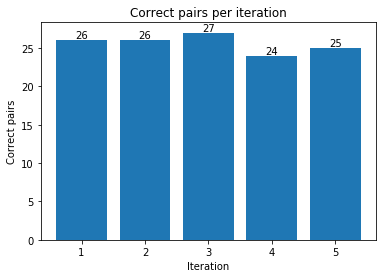

The avarage accuracy is: 0.512

######################################################################################################


In [11]:
################################################################################## No stopword but stemming
print("Stemming only\n")
accuracy_list.append(get_avarage_accuracy([corpus.product_reviews_2],target_words,stemming = True))

##### Applying both stopword removal and stemming.

Stemming and Stopword removal

1 time

[18 20 31 42 31 18 18 19  9 31 32 18 12  6 18 49 18 46 18 24  0 26 18 31
 47 18 18 31  0 21 18 18 43  5 21  2 30 14 18 49  7 40 18 38  4 18 16 31
 33 18 18 35 31 42 31 18 18 17 23 37 39 18  1  6 18 48 18 29 18  3 31 36
 18  0 41 18 18 31  0 21 18 18 28 11 45 15 10 34 18 31 22 27 18 25  8 18
 13 31 44 18]
Accuracy: 0.48

2 time

[16 39  4 40  4 16 16  5 26 32 30 16  7 27 16 42 16 35 16 36  4 17 16 40
 25 16 16 48  4 40 16 16 40 22  8  1  9 23 16  0 11 45 16 31 15 16  2  4
 41 16 16 34  4 40 16 16 16 20 12 32 21 16 19 27 16 43 16 38 16 10  4 44
 16 40 25 16 16 47  4 40 16 16 46  6 49 14 13 33 16  0 18 29 16 24  3 16
 28  4 37 16]
Accuracy: 0.54

3 time

[ 0 32 33  6 33  0  0  5 23 30 25  0 11 44  0 38  0 42  0  2 33 31  0 33
 40  0  0 49  0 16  0  0 46  3 29 14 27 26  0 33 10 22  0 36  9  0 19 33
 43  0  0 37 33  6 33  0  0 18 24 30 28  0 17 45  0 39  0 41  0 12 33 47
  0 33 48  0  0 49 33 16  0  0 46 20 16  1 13  8  0 33 21 34  0  7  4  0
 15 33 35

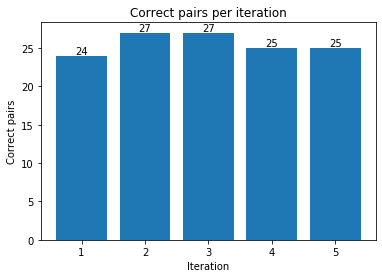

The avarage accuracy is: 0.512

######################################################################################################


In [12]:
################################################################################## Stopword and stemming
print("Stemming and Stopword removal\n")
accuracy_list.append(get_avarage_accuracy([corpus.product_reviews_2],target_words,remove_stopwords = True, stemming = True))

###### Visualizing the accuracy change

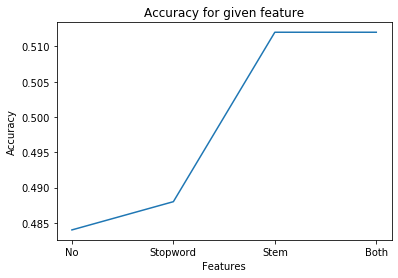

In [13]:
stem_stopword = ['No','Stopword','Stem','Both']
plt.plot(stem_stopword,accuracy_list)
plt.xlabel('Features')
plt.ylabel('Accuracy')
plt.title('Accuracy for given feature')
plt.show()

##### Displaying the average accuracy when the context size is increased

Context size 5

1 time

Accuracy: 0.48

2 time

Accuracy: 0.48

3 time

Accuracy: 0.54

4 time

Accuracy: 0.52

5 time

Accuracy: 0.44



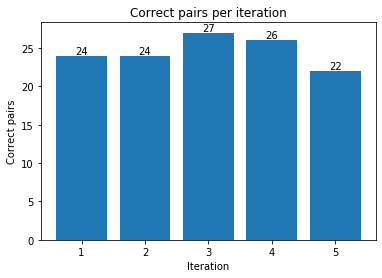

The avarage accuracy is: 0.492

######################################################################################################
Context size 10

1 time

Accuracy: 0.52

2 time

Accuracy: 0.48

3 time

Accuracy: 0.56

4 time

Accuracy: 0.54

5 time

Accuracy: 0.52



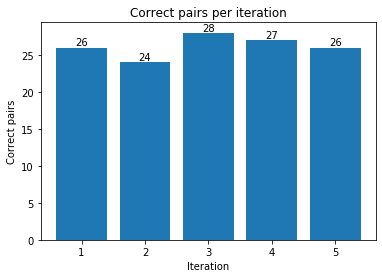

The avarage accuracy is: 0.524

######################################################################################################
Context size 15

1 time

Accuracy: 0.56

2 time

Accuracy: 0.58

3 time

Accuracy: 0.52

4 time

Accuracy: 0.58

5 time

Accuracy: 0.56



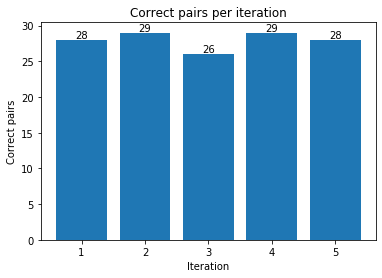

The avarage accuracy is: 0.56

######################################################################################################
Context size 25

1 time

Accuracy: 0.6

2 time

Accuracy: 0.6

3 time

Accuracy: 0.58

4 time

Accuracy: 0.6

5 time

Accuracy: 0.58



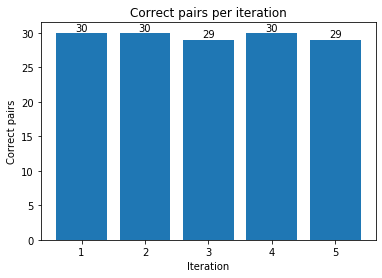

The avarage accuracy is: 0.592

######################################################################################################
Context size 40

1 time

Accuracy: 0.6

2 time

Accuracy: 0.6

3 time

Accuracy: 0.62

4 time

Accuracy: 0.66

5 time

Accuracy: 0.66



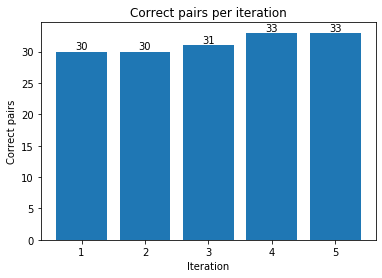

The avarage accuracy is: 0.628

######################################################################################################


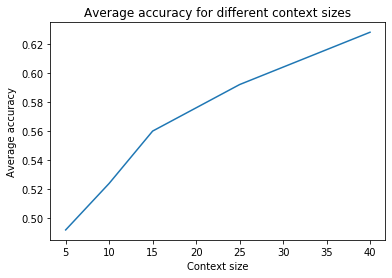

In [14]:
################################################################################## Context size incrementing
average_accuracy = []
context_sizes = [5,10,15,25,40]
print("Context size 5\n")
average_accuracy.append(get_avarage_accuracy([corpus.product_reviews_2],target_words,5,printing = False))
print("Context size 10\n")
average_accuracy.append(get_avarage_accuracy([corpus.product_reviews_2],target_words,10,printing = False))
print("Context size 15\n")
average_accuracy.append(get_avarage_accuracy([corpus.product_reviews_2],target_words,15,printing = False))
print("Context size 25\n")
average_accuracy.append(get_avarage_accuracy([corpus.product_reviews_2],target_words,25,printing = False))
print("Context size 40\n")
average_accuracy.append(get_avarage_accuracy([corpus.product_reviews_2],target_words,40,printing = False))
plt.plot(context_sizes,average_accuracy)
plt.xlabel('Context size')
plt.ylabel('Average accuracy')
plt.title('Average accuracy for different context sizes')
plt.show()

#### Running the program on the Brown corpus with different features (stopword removal, stemming or different context size).

##### No additional features applied.

No stemming and no stopword removal

1 time

[ 2 48 41  5 33 44  2 20 16 14 45  2  2  6 44  0  2 31  4  7 21 32  2  5
 23  5 44 35  2 46 38 49 15 30 28  5 40 11  2 22 24 19  5 34  1 18 48  2
 27  2  2 48 41  5 33 44  2  3 16 14 25  2  2 26 44 39  2 31 42 37 21 13
  2  5 23  5 44  8 44 12 38 49 36 43 28  5 29 11  2 22 17 19  5 10  9 47
  5  2 27  2]
Accuracy: 0.64

2 time

[31 21 43 21 33  1 31 26 18  5 16 31 31 44 21 42 31 39 35 14 20 38 31 21
 30 21  1 49  1 45  7 19 13 32 25 21 27 48 31 28 41 36 47  3  2 24 21  1
 22 31 31 21 43 21 33  1 31  4 18  5 16 31 31  8 21 15 31 39  6 40 20  0
 31 21 30 21  1  9  1 11  7 19 23 29 46 47 34 17 31 28 12 36 47 37 10 24
 21  1 22  1]
Accuracy: 0.64

3 time

[42 49 38 35 24  0 42 18 41 11 15 42 42 14  0 26 42 28  2 30 39 10 42 35
 20 35  0  9  0  5  4 28 27 22 29 12 32 16 42 21 33 37 12  8  1 23 35  0
 25 42 42 49 38 35 24  0 42  3 41 11 15 42 42 34  0 36 42 28 44  6 39 46
 42 35 20 35  0 40  0 47  4 28 13 22 43 12 17 16 42 21 19 37 12 31  7 45
 35

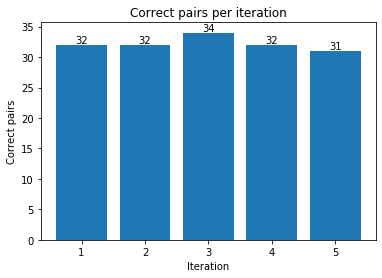

The avarage accuracy is: 0.644

######################################################################################################


In [15]:
################################################################################## No stopword and no stemming
accuracy_list = []
print("No stemming and no stopword removal\n")
accuracy_list.append(get_avarage_accuracy([corpus.brown],target_words))

##### Applying only stopword removal.

Stopword removal only

1 time

[10 21 49  0 38 45 10 20 23 19 39 10 10 42 45 24 10 31 44  7 43 11 10  0
 30  0 45  8 45 32  6 31 15 33 27  0 36 14 10  4 12 46 31  2  9 26  0 45
 17 10 10 21 49  0 38 45 10  3 23 19 16 10 10  5  0 48 10 31 22 25 28 34
 10  0 47  0 45 41 45 13  6 31 40 18 27  0 29 14 10  4 37 46 31 35  1 26
  0 45 17 10]
Accuracy: 0.64

2 time

[ 9 44 34  1 21 44  9 27 41 22 23  9  9 19 44 24  9 49 47  8 33 39  9  1
 17  1 44 40 48  7 13 31 12 20 25  1 32 10  9 18 16 30 31 37  3 26  1 48
 36  9  9 31 34  1 21 44  9  0 41 22 15  9  9 42 44 43  9 49  5 29 33  6
  9  1 17  1 44  2 48 28 13 31 35 46 25  1 45 10  9 18 38 30  1  4 11 26
  1 48 14  9]
Accuracy: 0.64

3 time

[ 6 46 38 23  2 42  6  9 29 24 45  6  6 35 42 26  6 47 43 31 28  0  6 23
 25 23 42 13 42 14 30  5 12 49 21  5  4 19  6  7 17 36  5 33 11 18 23 42
 48  6  6 46 38 23  2 42  6  3 29 24 15  6  6  8 23 39  6 47 27 10 28 44
  6 23 25 23 42 34 42 32 30  5 40 16 21  5 41 19  6  7 37 36  5 20  1 18
 23 42 22  6]
Acc

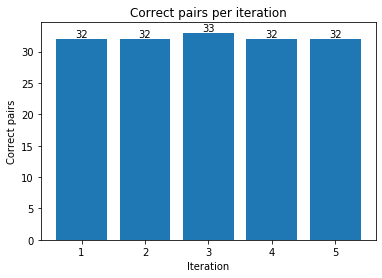

The avarage accuracy is: 0.644

######################################################################################################


In [16]:
################################################################################## Stopword and no stemming
print("Stopword removal only\n")
accuracy_list.append(get_avarage_accuracy([corpus.brown],target_words,remove_stopwords = True))

##### Applying only stemming.

Stemming only

1 time

[28 23 49 23 21  2 28  5 13 22 16 28 28 12  2 24 28 26 31 39  0 17 28 23
 15 44  2 20  2 36 43  9  7 41  6 27  4  8 28 11 18 45 23 30 14 34 23  2
 25 28 28 23 49 23 21  2 28 32 40 22 16 28 28 46  2 24 28 26 31 10 47 17
 28 23 35 38  2 29  2  3 43  9 33 19  6 27 37 48 28 11 42 45 23 30  1 34
 23  2 25 28]
Accuracy: 0.7

2 time

[17 48 47 34  8  3 17  5 37  9 39 17 17  6  3  0 17 35 13 43 28 21 17 48
 29 27  3 45  3 14 36 22  7  4 31 23 18 49 17 42  2 15 48 44  1 40 48  3
 26 17 17 48 47 34  8  3 17 33 24  9 11 17 17  6  3  0 17 35 13 25 28 21
 17 48 19 27  3 10  3 46 36 22 30 38 31 23 18 12 17 32 41 15 48 20 16 40
 48  3 26 17]
Accuracy: 0.72

3 time

[28 25 48 25 13  1 28 35 20  8 10 28 28 18  1 29 28 27 32 17  3 12 28 25
 15 33  1 19  1  5 34 49  9 21 23 22  7 36 28 26  0  6 25 16  2 30 25  1
 24 28 28 25 48 25 13  1 28  4 31  8 39 28 28 46  1 29 28 27 32 44  3 12
 28 25 41 33  1 19  1 40 34 49 37 42 23 47 38 11 28 26 43  6 25 45 14 30
 25  1 24 28]
Accuracy: 0.

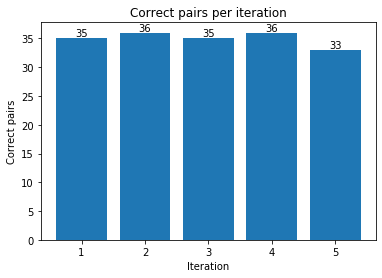

The avarage accuracy is: 0.7

######################################################################################################


In [17]:
################################################################################## No stopword but stemming
print("Stemming only\n")
accuracy_list.append(get_avarage_accuracy([corpus.brown],target_words,stemming = True))

##### Applying both stopword removal and stemming.

Stemming and Stopword removal

1 time

[43 15 44 15 21  0 43 37 31 16 47 43 43  8  0 34 43 27 20  9  3 24 43 15
 30 29  0 12  0 35  7 26 38 18 36 28 22 13 43 17 41 48 15 40  2 33 15  0
 19 43 43 15 44 15 21  0 43  6 11 16 10 43 43 49  0 34 43 27 20 45  3 24
 43 15 25 29  0 46  0 14  7 26  4 32 36 28 39 42 43 17  5 48 15  1 23 33
 15  0 19 43]
Accuracy: 0.7

2 time

[39 14 46 14 32  0 39 29 24 20 49 39 39 15  0 22 39 34 26 31 27  7 39 14
 11  3  0 43  0 48  6 38 44 18 41 25 23 45 39 28 10 14 14 36  2 33 46  0
 16 39 39 14 46 14 32  0 39  4 19 20 12 39 39 15  0 22 39 34 26 13 27  7
 39 14 37  3  0  8  0  9  6 38  5 40 42 25 47 21 39 30 35 14 14  1 17 33
 14  0 16 39]
Accuracy: 0.66

3 time

[ 2 13 29 13 31 29  2  5 15 24 20  2  2 21 29 30  2  4 11  6 34  0  2 13
 33 26 29 16 29 47  9 38 32 35 25 27 49 40  2 48 19 44 13 41  1 37 13 29
 22  2  2 13 29 13 31 29  2 28 39 24 43  2  2 42 29 30  2  4 11 36 34  0
  2 13 10 26 29 45 29 12  9 38  7 23 25 27  3  8  2 17 46 44 13 18 14 37
 13 29 22 

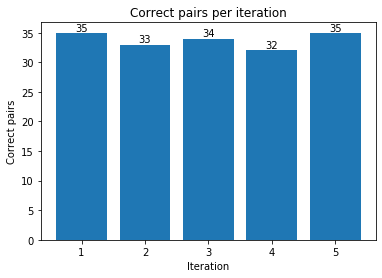

The avarage accuracy is: 0.6759999999999999

######################################################################################################


In [18]:
################################################################################## Stopword and stemming
print("Stemming and Stopword removal\n")
accuracy_list.append(get_avarage_accuracy([corpus.brown],target_words,remove_stopwords = True, stemming = True))

###### Visualizing the accuracy change

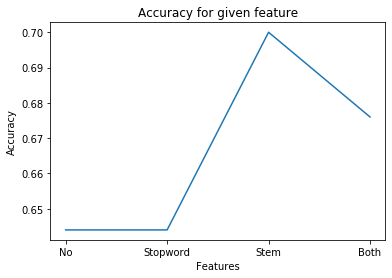

In [19]:
plt.plot(stem_stopword,accuracy_list)
plt.xlabel('Features')
plt.ylabel('Accuracy')
plt.title('Accuracy for given feature')
plt.show()

##### Displaying the average accuracy when the context size is increased

Context size 5

1 time

Accuracy: 0.66

2 time

Accuracy: 0.62

3 time

Accuracy: 0.64

4 time

Accuracy: 0.6

5 time

Accuracy: 0.62



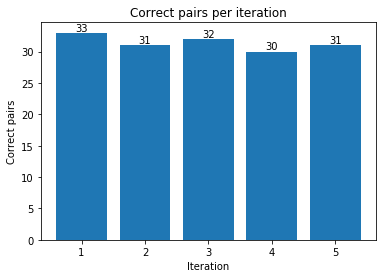

The avarage accuracy is: 0.628

######################################################################################################
Context size 10

1 time

Accuracy: 0.72

2 time

Accuracy: 0.68

3 time

Accuracy: 0.66

4 time

Accuracy: 0.74

5 time

Accuracy: 0.72



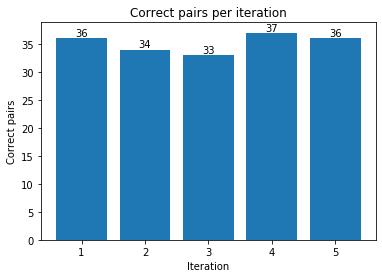

The avarage accuracy is: 0.704

######################################################################################################
Context size 15

1 time

Accuracy: 0.74

2 time

Accuracy: 0.72

3 time

Accuracy: 0.74

4 time

Accuracy: 0.74

5 time

Accuracy: 0.7



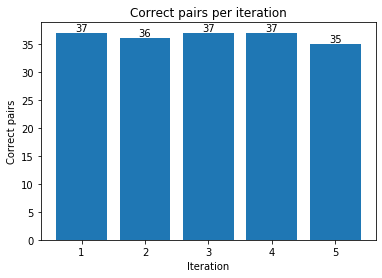

The avarage accuracy is: 0.7280000000000001

######################################################################################################
Context size 25

1 time

Accuracy: 0.8

2 time

Accuracy: 0.8

3 time

Accuracy: 0.82

4 time

Accuracy: 0.8

5 time

Accuracy: 0.8



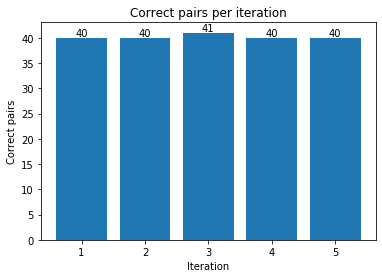

The avarage accuracy is: 0.8039999999999999

######################################################################################################
Context size 40

1 time

Accuracy: 0.84

2 time

Accuracy: 0.84

3 time

Accuracy: 0.86

4 time

Accuracy: 0.86

5 time

Accuracy: 0.84



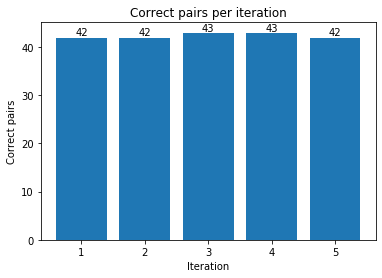

The avarage accuracy is: 0.8480000000000001

######################################################################################################


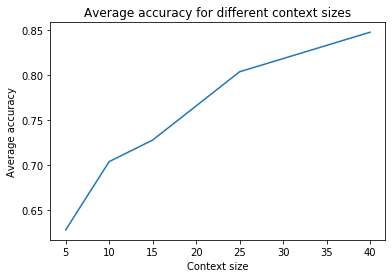

In [20]:
################################################################################## Context size incrementing
average_accuracy = []
print("Context size 5\n")
average_accuracy.append(get_avarage_accuracy([corpus.brown],target_words,5,printing = False))
print("Context size 10\n")
average_accuracy.append(get_avarage_accuracy([corpus.brown],target_words,10,printing = False))
print("Context size 15\n")
average_accuracy.append(get_avarage_accuracy([corpus.brown],target_words,15,printing = False))
print("Context size 25\n")
average_accuracy.append(get_avarage_accuracy([corpus.brown],target_words,25,printing = False))
print("Context size 40\n")
average_accuracy.append(get_avarage_accuracy([corpus.brown],target_words,40,printing = False))
plt.plot(context_sizes,average_accuracy)
plt.xlabel('Context size')
plt.ylabel('Average accuracy')
plt.title('Average accuracy for different context sizes')
plt.show()

#### Running the program on the combined corpus (Product reviews corpus and the Brown corpus) with different features (stopword removal, stemming or different context size).

In [21]:
combined_corpora = [corpus.product_reviews_2,corpus.brown]

##### No additional features applied.

No stemming and no stopword removal

1 time

[ 7 36 34 21 48 31  7  3 33 17 13  7 32 37 31 46  7 49  4 40 25 42  7 21
 24 21 31 14 31 43 39  5  9 47 19 18 28 22  7 30 35 45  5 38  1 27 18 31
 16  7  7 36 34 21 48 31  7 23 33 17 13  7 32 12 31 26  7 49 44 10 25  0
  7 21 24 21 31 41 31 11 39  5 29 20 19 18 28 22  7 30 15 45  5  6  8 27
  2 31 16  7]
Accuracy: 0.72

2 time

[17 31 40 24 20  0 17  3 27  9 38 17 37 47  0 29 17 41 21 13  5  6 17 24
 32  0  0  2  0 16 26 30 12 44 15 48 43 23 17 33 36 22 30 39  1 49 11  0
 19 17 17 31 40 24 20  0 17 28 27  9 18 17 37  7  0 29 17 41 21 42  5  6
 17 24 32  0  0 46  0 35 26 30 45 14 15 48 34 23 17 33  8 22 30  4 10 25
 11  0 19 17]
Accuracy: 0.74

3 time

[11 17 47 48 17 34 11 22 29 21 38 11 37  5 34  7 11  9 18  4 32 36 11 48
  3 34 34  8 34 25 27  0 44 20 12 40  2 15 11 30 24 26  0 28 16 31 41 34
 23 11 11 17 47 48 17 34 11  6 29 21 14 11 37 33 34  7 11  9 18 35 32 10
 11 48 49 34 34 45 34 19 27  0 13 46 12 40 42 15 11 30 39 26  0 43  1 31
 41

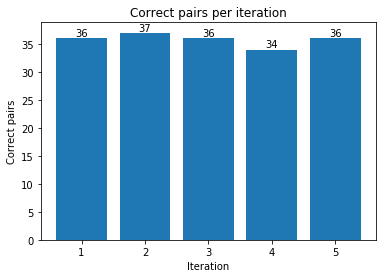

The avarage accuracy is: 0.716

######################################################################################################


In [22]:
################################################################################## No stopword and no stemming
accuracy_list = []
print("No stemming and no stopword removal\n")
accuracy_list.append(get_avarage_accuracy(combined_corpora,target_words))

##### Applying only stopword removal.

Stopword removal only

1 time

[ 0 21 36 12 32 46  0 24 30  9 49  0 37  6 46 16  0 28 25 33  4 45  0 12
 26 46 46 39 46 34 31 47 35 22 19 41 38 20  0 17  2  5 47  8  1 27 42 46
 23  0  0 21 36 12 32 46  0  3 30  9 18  0 37 48 46 16  0 28 25 14  4 10
  0 12 43 12 46  7 46 15 31 47 13 22 19 41 29 20  0 17 44  5 46 40 11 27
 42 46 23  0]
Accuracy: 0.7

2 time

[ 4 20 24  0 39 34  4  3 38 23 49  4 35 32 34 48  4 27 25 30 28 47  4  0
 26 34 34 10 34 43 17  0 13 21  9 41  2 12  4 36 16 45  0 44  6 18 37 34
 19  4  4 20 24  0 39 34  4 22 38 23 15  4 35 14 34  5  4 27 33 11 28  7
  4  0 26 34 34 10 34  8 17  0 31 40  9 41 46 12  4 36 42 45  0 29  1 18
 37 34 19  4]
Accuracy: 0.72

3 time

[ 6  3 38 17 41 36  6  4 28 22 11  6 30 12 36 25  6 33 21 29 18 16  6 17
 23 36 36  2 36 14 39 47 31 44 19 35 46 20  6  8  9 32 47  5 10 49 43 36
  0  6  6  3 38 17 41 36  6 27 28 22 11  6 30 37 36 25  6 33 21  7 18 42
  6 17 23 36 36 34 36 45 39 47 13 26 19 35 24 20  6  8 40 32 47 48  1 15
 43 36  0  6]
Accu

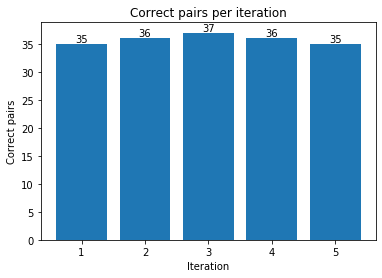

The avarage accuracy is: 0.716

######################################################################################################


In [23]:
################################################################################## Stopword and no stemming
print("Stopword removal only\n")
accuracy_list.append(get_avarage_accuracy(combined_corpora,target_words,remove_stopwords = True))

##### Applying only stemming.

Stemming only

1 time

[ 7 21 41 21 31 35  7 34 16 23 11  7 41  0 35 24  7 27  5 45 30 20  7  1
 36 29 35 18 35  9 32 49 10 44 26 47 43  6  7 22 39 42  1 28 12 14 21 35
 25  7  7 21 41  1 31 35  7  4 33 23 11  7 41 48 35 24  7 27  5  8 30 20
  7  1 17 29 35 18 35 37 32 49 38 13 26 15  3 40  7 22 19 42  1 46  2 14
 21 35 25  7]
Accuracy: 0.7

2 time

[17  8 31  8 23  1 17 40  3 24 20 17 31 11  1 49 17 32 26 15  5 14 17  8
 35 33  1  9  1 30 34 41  7 19  0 22 38 13 17 39 21 45  1 29  2 28 48  1
 27 17 17  8 31  8 23  1 17  6 37 24 20 17  8 11  1 25 17 32 26 15  5 14
 17  8  4 33  1 44  1 16 34 41 43 46  0 36 10 42 17 12 47 45 41 29 18 28
 48  1 27 17]
Accuracy: 0.68

3 time

[ 3 17 45 27 19 36  3  5 43 10 20  3 27 16 36 23  3 39 24 21 11 25  3 27
 12 41 36 14 36 46  1 48  8 38  4 13 47  9  3  7  0 49 27 28  2 33 42 36
 30  3  3 17 45 27 19 36  3 34 26 10 44  3 27 16 36 23  3 39 24 40 11 25
  3 27 31 41 36 14 36 15  1 48 35  6  4 32 29  9  3  7 37 49 27 22 18 33
 42 36 30  3]
Accuracy: 0.

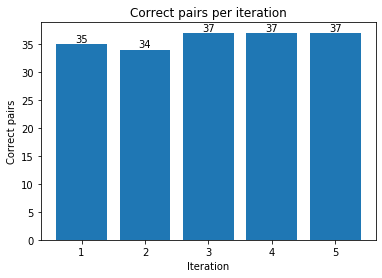

The avarage accuracy is: 0.7200000000000001

######################################################################################################


In [24]:
################################################################################## No stopword but stemming
print("Stemming only\n")
accuracy_list.append(get_avarage_accuracy(combined_corpora,target_words,stemming = True))

##### Applying both stopword removal and stemming.

Stemming and Stopword removal

1 time

[ 6 14  0 43 31 28  6  4 10 29 41  6  0  5 28 30  6 21 22 47 38 25  6 43
 20 34 28 15 28 44 35 40  9 32  7 37  1  8  6 39 19 49 43 18  2  3 14 28
 26  6  6 14  0 43 31 28  6 33 36 46 12  6 14  5 28 30  6 21 22 11 38 25
  6 43 45 34 28 48 28 13 35 40 27 16  7 24 42  8  6 23 19 49 43 18 17  3
 14 28 26  6]
Accuracy: 0.7

2 time

[ 4 11 45 31 22 48  4  3 34  7 23  4 45 25 48 19  4 36 15 49 30  5  4 31
 43 35 48 14 48 16 32  0 44 40  8 37 38 12  4  6  2 46 31 10 20 28 42 48
 29  4  4 11 45 11 22 48  4 27 24  7 23  4 45 25 48 19  4 36 15 21 30  5
  4 31 17 35 48 14 48 41 32  0  9 13  8 18 26 12  4 39 47 46 31 33  1 28
 42 48 29  4]
Accuracy: 0.72

3 time

[26  7 36  7 28  2 26  5 31 17 34 26 39  6  2 25 26 16 35 48  0 22 26 42
 44 24  2 18  2 10 37 49 40 15 30 19 41  8 26 47  3 43 42 46 20 33  7  2
 23 26 26  7 36  7 28  2 26 27 21 17 13 26 39  6  2 25 26 16 35 11  0 22
 26 42 14 24  2 18 42 10 37 49  9 38 30 19  4 45 26 12 32 43 42 29  1 33
  7  2 23 

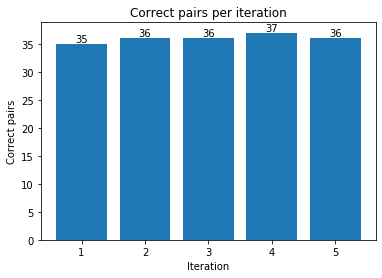

The avarage accuracy is: 0.72

######################################################################################################


In [25]:
################################################################################## Stopword and stemming
print("Stemming and Stopword removal\n")
accuracy_list.append(get_avarage_accuracy(combined_corpora,target_words,remove_stopwords = True, stemming = True))

###### Visualizing the accuracy change

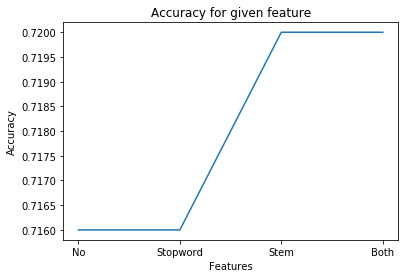

In [26]:
plt.plot(stem_stopword,accuracy_list)
plt.xlabel('Features')
plt.ylabel('Accuracy')
plt.title('Accuracy for given feature')
plt.show()

##### Displaying the average accuracy when the context size is increased

Context size 5

1 time

Accuracy: 0.72

2 time

Accuracy: 0.74

3 time

Accuracy: 0.7

4 time

Accuracy: 0.72

5 time

Accuracy: 0.74



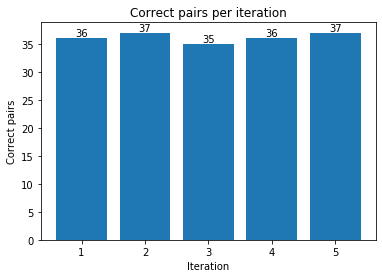

The avarage accuracy is: 0.724

######################################################################################################
Context size 10

1 time

Accuracy: 0.74

2 time

Accuracy: 0.74

3 time

Accuracy: 0.72

4 time

Accuracy: 0.74

5 time

Accuracy: 0.74



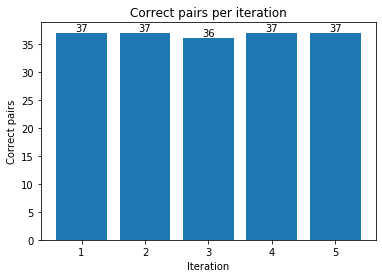

The avarage accuracy is: 0.7360000000000001

######################################################################################################
Context size 15

1 time

Accuracy: 0.8

2 time

Accuracy: 0.78

3 time

Accuracy: 0.78

4 time

Accuracy: 0.78

5 time

Accuracy: 0.76



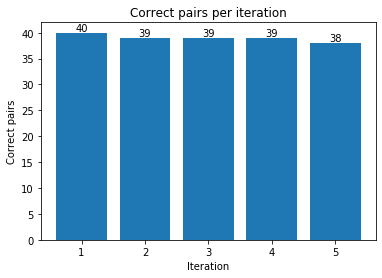

The avarage accuracy is: 0.78

######################################################################################################
Context size 25

1 time

Accuracy: 0.84

2 time

Accuracy: 0.84

3 time

Accuracy: 0.82

4 time

Accuracy: 0.86

5 time

Accuracy: 0.84



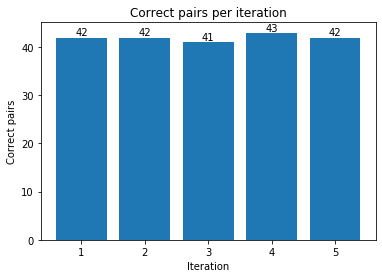

The avarage accuracy is: 0.8400000000000001

######################################################################################################
Context size 40

1 time

Accuracy: 0.86

2 time

Accuracy: 0.88

3 time

Accuracy: 0.84

4 time

Accuracy: 0.88

5 time

Accuracy: 0.82



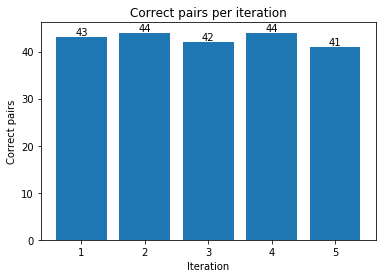

The avarage accuracy is: 0.8560000000000001

######################################################################################################


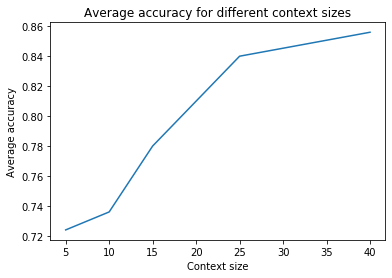

In [27]:
################################################################################## Context size incrementing
average_accuracy = []
print("Context size 5\n")
average_accuracy.append(get_avarage_accuracy(combined_corpora,target_words,5,printing = False))
print("Context size 10\n")
average_accuracy.append(get_avarage_accuracy(combined_corpora,target_words,10,printing = False))
print("Context size 15\n")
average_accuracy.append(get_avarage_accuracy(combined_corpora,target_words,15,printing = False))
print("Context size 25\n")
average_accuracy.append(get_avarage_accuracy(combined_corpora,target_words,25,printing = False))
print("Context size 40\n")
average_accuracy.append(get_avarage_accuracy(combined_corpora,target_words,40,printing = False))
plt.plot(context_sizes,average_accuracy)
plt.xlabel('Context size')
plt.ylabel('Average accuracy')
plt.title('Average accuracy for different context sizes')
plt.show()